## **Import the Dependencies**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
import pickle

## **Data Collection and Processing**

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
df.shape

(8523, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [6]:
categorical_cols = []

for col in df.columns:
  if df[col].dtype == 'object':
    categorical_cols.append(col)

In [7]:
categorical_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

## **Handling Missing Values**

In [8]:
df['Item_Weight'].mean()

12.857645184135976

In [9]:
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)

<ipython-input-9-3985e38a6a0e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)


In [10]:
df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [11]:
df['Outlet_Size'].mode()

,Outlet_Size
0,Medium


In [12]:
outlet_size_mode = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [13]:
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [14]:
missing_values = df['Outlet_Size'].isnull()

In [15]:
missing_values

,Outlet_Size
0,False
1,False
2,False
3,True
4,False
...,...
8518,False
8519,True
8520,False
8521,False


In [16]:
df.loc[missing_values, 'Outlet_Size'] = df.loc[missing_values, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

In [17]:
df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


## **Data Analysis**

In [18]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [19]:
sns.set()

#### For Numerical Features

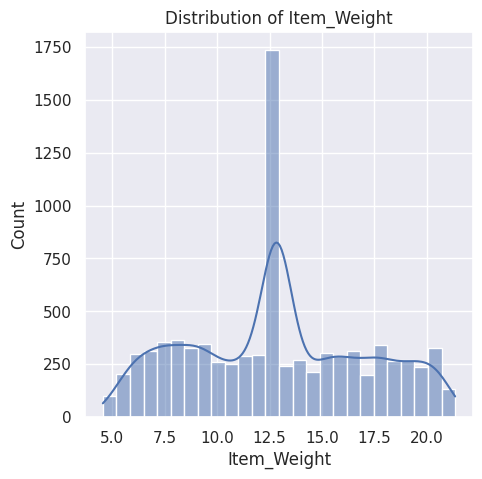

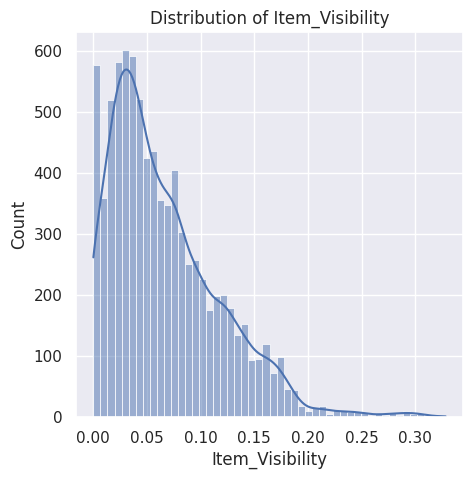

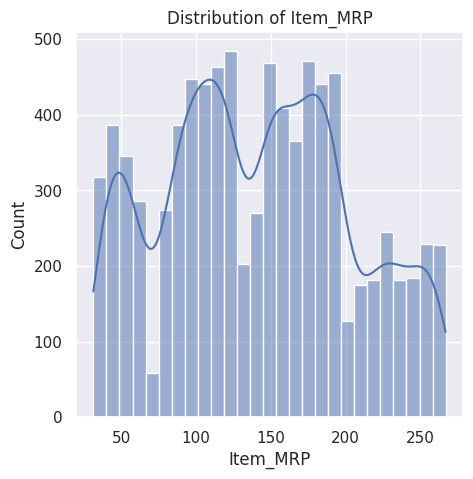

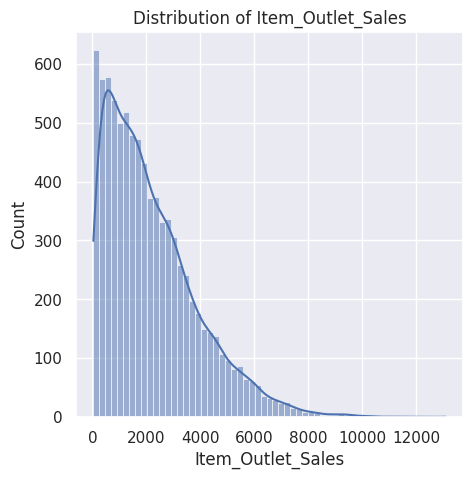

In [20]:
cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

for col in cols:
    plt.figure(figsize=(5, 5))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')

#### For Categorical Features

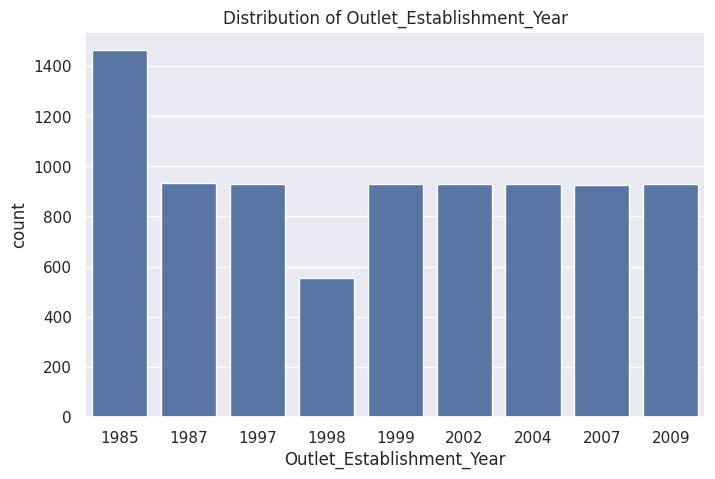

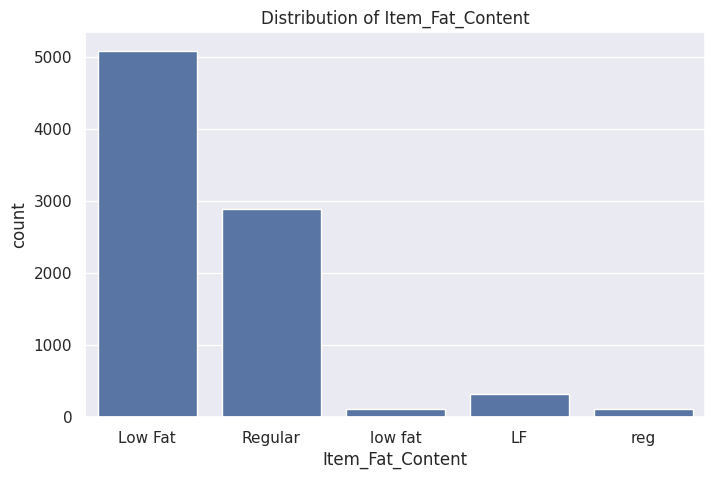

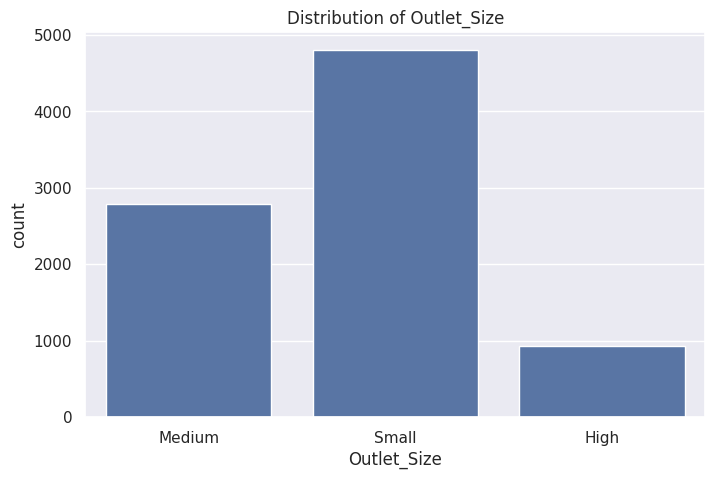

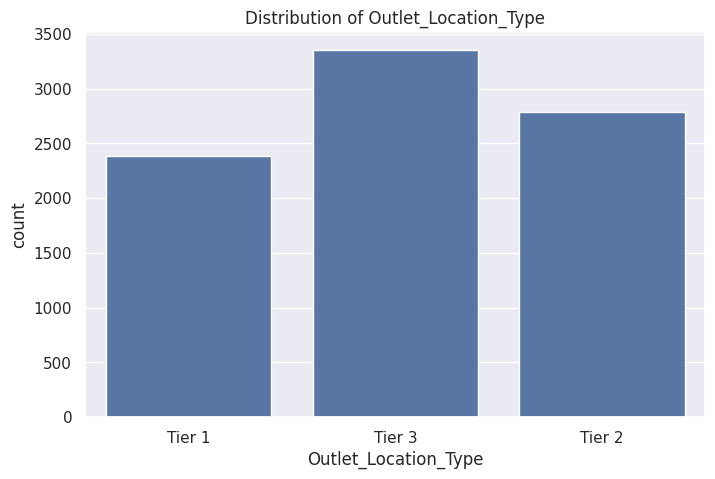

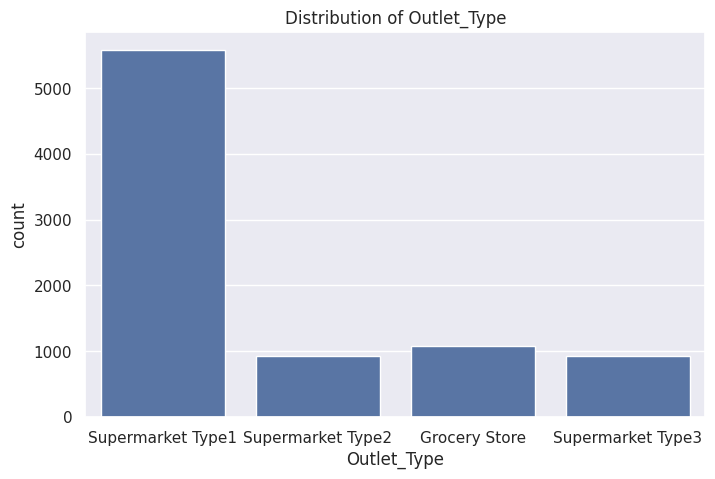

In [21]:
cols = ['Outlet_Establishment_Year', 'Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

for col in cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(x = col, data = df)
    plt.title(f'Distribution of {col}')

Text(0.5, 1.0, 'Distribution of Item_Type')

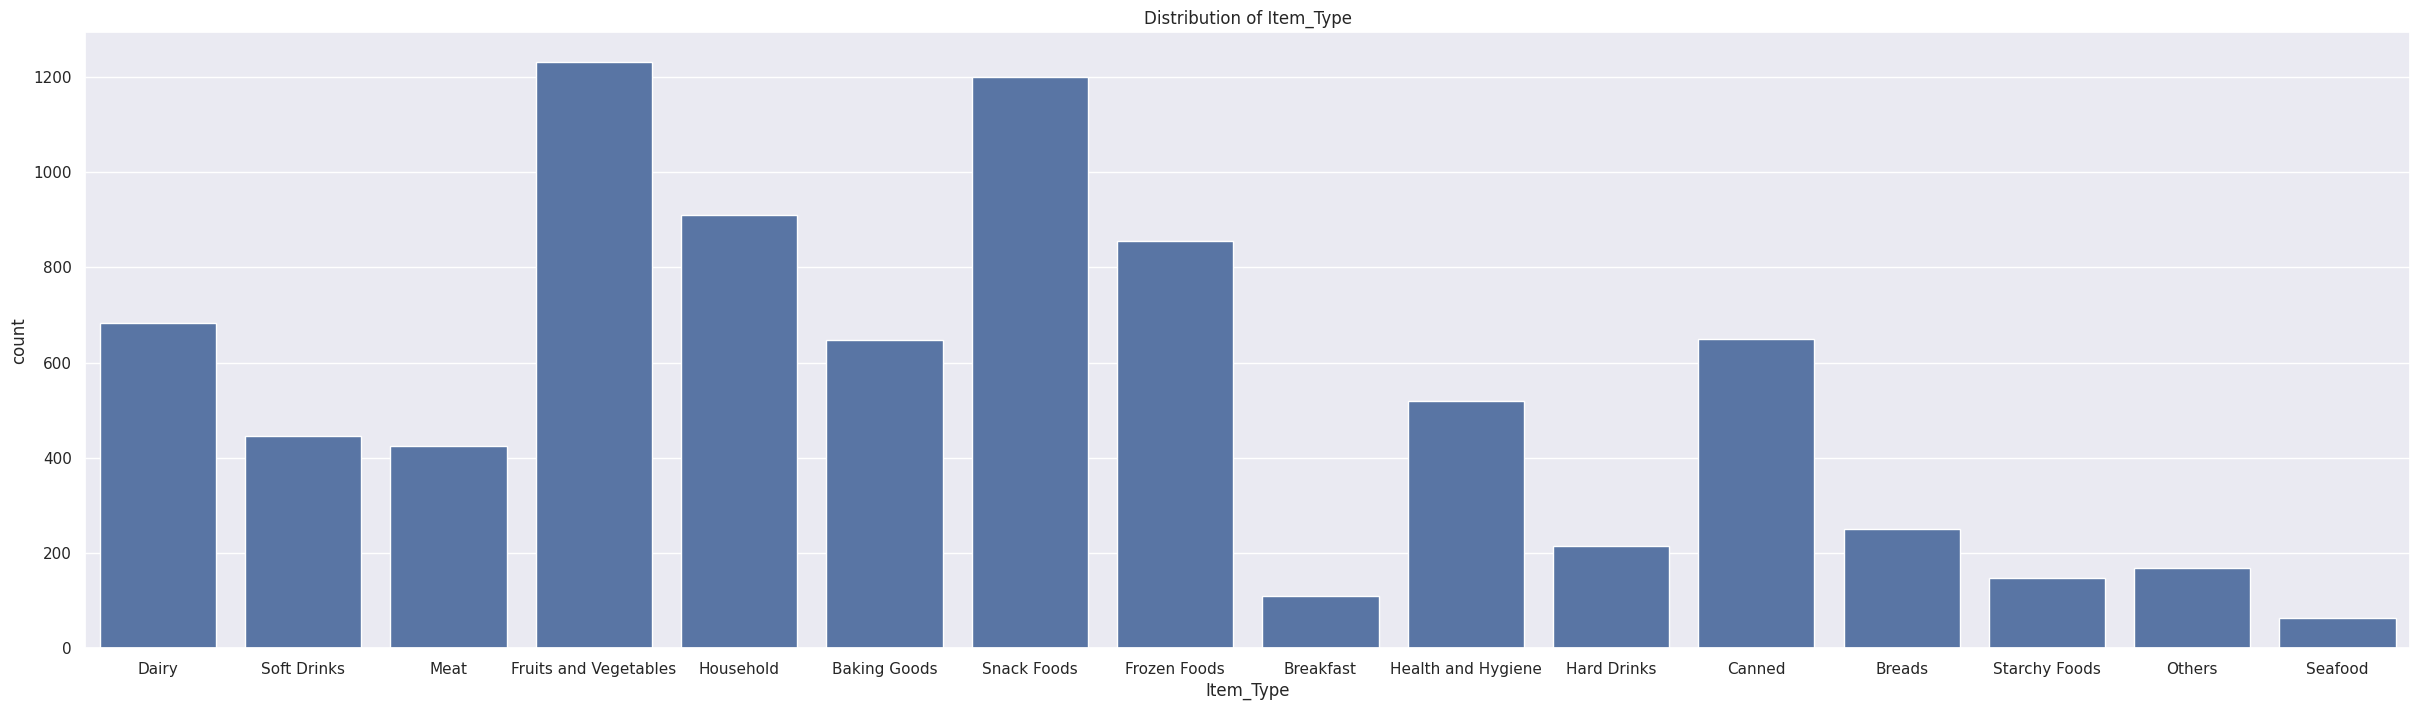

In [22]:
    plt.figure(figsize=(30, 8))
    sns.countplot(x = 'Item_Type', data = df)
    plt.title('Distribution of Item_Type')

## **Data Pre-Processing**

In [23]:
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5089
Regular,2889
LF,316
reg,117
low fat,112


In [24]:
df.replace({'Item_Fat_Content' : {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [25]:
df.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


In [26]:
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


## **Label Encoding**

In [27]:
encoder = LabelEncoder()

In [28]:
object_columns = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

encoders = {}

for col in object_columns:
  label_encoder = LabelEncoder()
  df[col] = label_encoder.fit_transform(df[col])
  encoders[col] = label_encoder

# Save encoders for future use
with open("retail_encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)

In [29]:
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700


## **Splitting the data into Train and Test**

In [30]:
X = df.drop(columns='Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']

In [31]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [32]:
print(y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


## **Model Training**

In [35]:
regressor = XGBRegressor()

In [36]:
regressor = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50
)
regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

with open("retail_model.pkl", "wb") as file:
    pickle.dump(regressor, file)

## **Model Evaluation**

In [37]:
y_train_pred = regressor.predict(X_train)

In [38]:
y_train_pred

array([2932.4302, 2780.9758, 1808.7032, ..., 4140.5654, 1886.1595,
       1538.9968], dtype=float32)

In [39]:
r2_train = metrics.r2_score(y_train, y_train_pred)

In [40]:
r2_train

0.6530853675343727

In [41]:
y_test_pred = regressor.predict(X_test)

In [42]:
y_test_pred

array([1302.2004 ,  925.36755,  768.5441 , ...,  754.7865 ,  727.9581 ,
       1707.6523 ], dtype=float32)

In [43]:
r2_test = metrics.r2_score(y_test, y_test_pred)

In [44]:
r2_test

0.6090312350554463

In [45]:
# Load Label Encoders
with open("retail_encoders.pkl", "rb") as f:
    encoders = pickle.load(f)

# Load trained model
with open("retail_model.pkl", "rb") as f:
    model = pickle.load(f)

def preprocess_input(user_input, encoders):
    """
    Converts user input dictionary into a model-friendly format.
    Encodes categorical variables using the saved encoders.
    """
    processed_input = []

    for col, value in user_input.items():
        if col in encoders:
            processed_input.append(encoders[col].transform([value])[0])  # Encode categorical
        else:
            processed_input.append(value)  # Keep numerical as-is

    return np.array(processed_input).reshape(1, -1)  # Reshape for prediction

def predict_sales(user_input):
    """
    Takes user input as a dictionary, processes it, and predicts sales.
    """
    # Preprocess the input
    input_data = preprocess_input(user_input, encoders)

    # Make prediction
    prediction = model.predict(input_data)

    # Output result
    return f"Predicted Sales: ₹{prediction[0]:.2f}"

# Sample user input
user_input = {
    "Item_Identifier": "FDN15",
    "Item_Weight": 17.50,
    "Item_Fat_Content": "Low Fat",  # Encoded
    "Item_Visibility": 0.016760,
    "Item_Type": "Meat",  # Encoded
    "Item_MRP": 141.6180,
    "Outlet_Identifier": "OUT049",  # Encoded
    "Outlet_Establishment_Year": 1999,
    "Outlet_Size": "Medium",  # Encoded
    "Outlet_Location_Type": "Tier 1",  # Encoded
    "Outlet_Type": "Supermarket Type1"  # Encoded
}

# Run prediction
print(predict_sales(user_input))


Predicted Sales: ₹2117.28
